# Introduction

In this notebook, we deal with the Kaggle House Prices dataset <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview">https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview</a>, we will use the `train.csv` to train a high performance model and use it to make predictions for the data in `test.csv`.  This notebook contains the following 4 parts:

- Data Cleaning: We deal with the numerical features and categorical features separately. We select features which are high correlated with the `SalePrice` as our predictors.
- Model Development: We train 4 models `Lasso Regression, Ridge Regression, Random Forest Regressor, XGBoost regressor` on the training set.

- Model Evaluation: We use the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price as the evaluation metric.
- Make Predictions: We select `XGBoost regressor` which has the best performance to predict the house price. 

The prediction is saved in a file named `submission.csv`.

In [1]:
# import all packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost

from seaborn import set_style
set_style('whitegrid')

## Data Exploration

In [2]:
# Load the data set
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# The size of the training set and test set
print('The size of the training set is: ', train.shape)
print('The size of the test set is: ', test.shape)
train.head()

The size of the training set is:  (1460, 81)
The size of the test set is:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Next let us look at the distribution of the `SalePrice`.

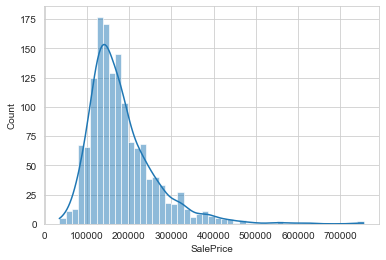

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
# The histogram shows the distribution of the houses price
sns.histplot(train['SalePrice'], kde=True)
plt.show()
train['SalePrice'].describe()

From the statistics, the `SalePrice` has mean 180921.2 and median 163000, with standard deviation 79442.5. The histogram shows that the distribution of `SalePrice` is right_skewed.

In [5]:
# The Id of the training set is not a feature, we set it as index
train.set_index('Id', inplace=True)
test.set_index('Id', inplace=True)

## Deal with Missing values
We look at the features that have missing data. We find that columns `[PollQC, MiscFeature, Alley, Fence, FireplaceQu]` have more 47% of the data missing, we decide to drop these columns. Though `LotFrontage` has around 17% of the data missing, we keep it as it seems an important feature to predict the price.

In [6]:
# Find the columns with NaN, sort them in decreasing order.
# Compute the percent of missing data.
columns_with_nan = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[train.isnull().sum() > 0],
                                columns = ['Number_of_nan'])
columns_with_nan['%_of_nan'] = columns_with_nan['Number_of_nan']/len(train)*100

columns_with_nan

,Number_of_nan,%_of_nan
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageCond,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


In [7]:
# We decide to drop columns [PollQC, MiscFeature, Alley, Fence, FireplaceQu], 
# which have more than 47% of the data missing 

columns_to_drop = list(columns_with_nan[columns_with_nan['%_of_nan'] > 40].index)
print('We will drop columns with missing value > 40% of the data, they are: \n', columns_to_drop)

# drop the columns in training set and test set
train.drop(columns_to_drop, inplace=True, axis=1)
test.drop(columns_to_drop, inplace=True, axis=1)

We will drop columns with missing value > 40% of the data, they are: 
 ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


## Numerical Features
Next we focus on the numerical features of the training set, we are going to do some exploratory data analysis. We will analyze the correlation of features with `SalePrice`, and keep those features with high correlation and drop those with low correlation.

In [8]:
# We select all numerical columns, whose dtype are 'int64' or 'float64', which are not 'object'
numerical_columns = [column for column in train.columns if train[column].dtype != 'object']

numerical_columns_test = [column for column in test.columns if test[column].dtype != 'object']

# We store all the numerical features in train_num and test_num
train_num = train[numerical_columns].copy()
test_num = test[numerical_columns_test].copy()

print('The number of numerical features for training set is: ', len(numerical_columns))
print('The number of numerical features for test set is: ', len(numerical_columns_test))
train_num.head()

The number of numerical features for training set is:  37
The number of numerical features for test set is:  36


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


### Feature selection
Next we compute the correlations between the numerical features and `SalePrice`. We do the following analysis:
- We keep those features with absolute value of the correlation is >= 0.2, and drop the weak correlated features as they have little impact to the `SalePrice`.
- We also look at the correlations between features, if a pair of features are strongly correlated with each other, we only keep one of them, since they have almost same impact to the `SalePrice`.

In [9]:
# We compute the correlation between all numerical features and SalePrice.
# The correlation matrix

corr_matrix = train_num.corr().round(2)

# Take the absolute value of the correlations with SalePrice and sort them in descending order
correlation = np.abs(corr_matrix['SalePrice']).sort_values(ascending=False)
print('The correlations of features with SalePrice are:')
corr_df = pd.DataFrame(correlation)
corr_df.columns = ['corr_with_SalePrice']
corr_df

The correlations of features with SalePrice are:


,corr_with_SalePrice
SalePrice,1.00
OverallQual,0.79
GrLivArea,0.71
GarageCars,0.64
GarageArea,0.62
TotalBsmtSF,0.61
1stFlrSF,0.61
FullBath,0.56
TotRmsAbvGrd,0.53
YearBuilt,0.52


The following scatter plots shows the relationship of `OverallQual, GrLivArea, GarageArea` with `SalePrice`.

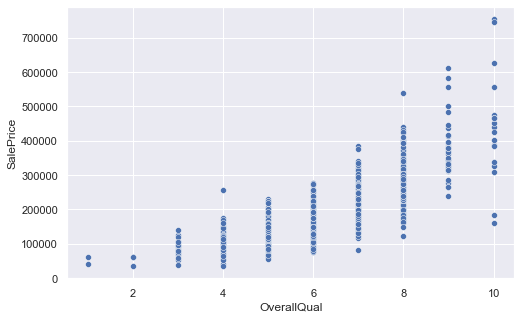

In [10]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.scatterplot(x = train_num['OverallQual'], y = train_num['SalePrice'])
plt.show()

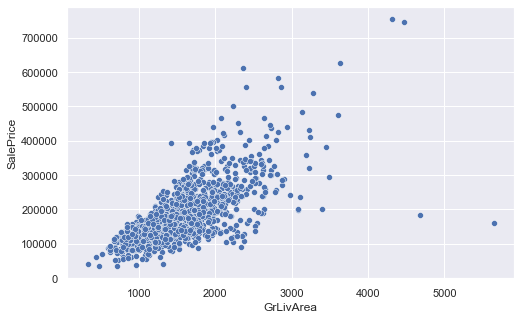

In [11]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.scatterplot(x = train_num['GrLivArea'], y = train_num['SalePrice'])
plt.show()

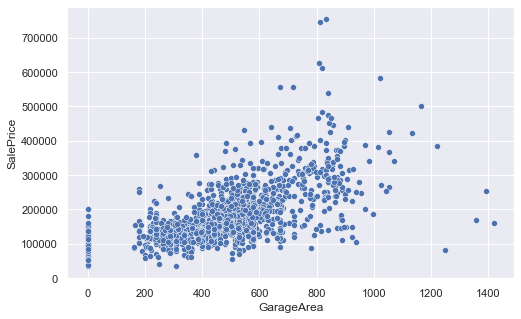

In [12]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.scatterplot(x = train_num['GarageArea'], y = train_num['SalePrice'])
plt.show()

Next we look at the heatmap of the correlations between the strong correlated features. 

The strong correlated numerical features in descending orders are:
  ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF']


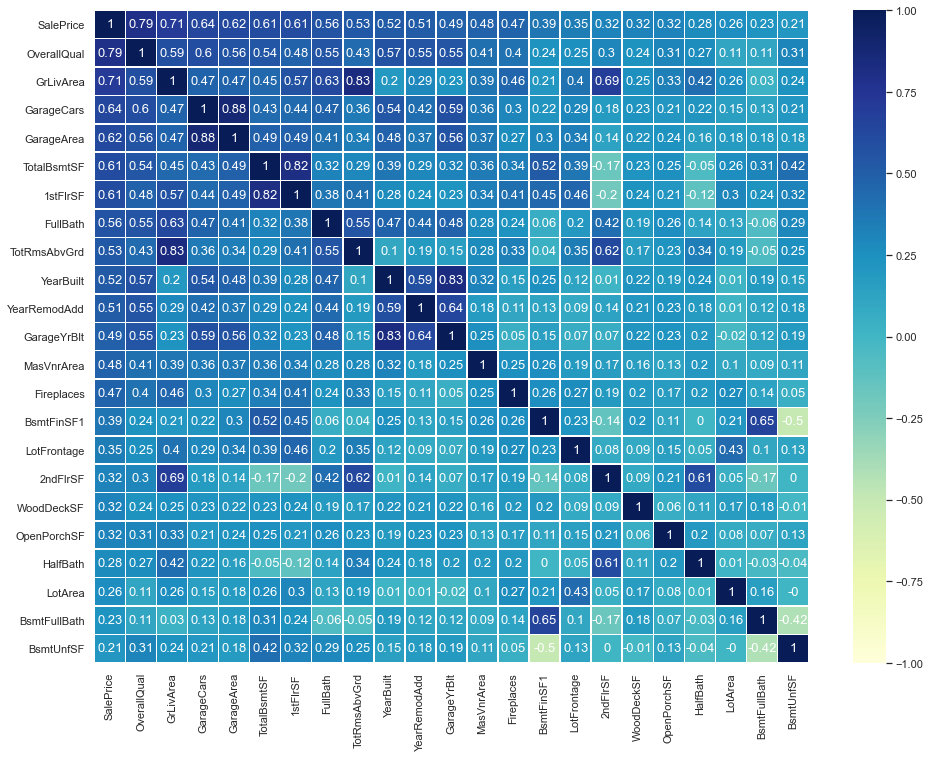

In [13]:
# We keep features which have correlation with SalePrice >= 0.2 and store the features in strong_corr_columns
strong_corr_columns = list(correlation[(correlation >= .2)].index)
print('The strong correlated numerical features in descending orders are:\n ', strong_corr_columns)

# We show the heatmap of the correlation matrix with strong_corr_columns

plt.subplots(figsize = (16,12))
sns.heatmap(corr_matrix.loc[strong_corr_columns, strong_corr_columns],
            vmax=1, vmin=-1,
            annot_kws={"size": 13, "color": "white"},
            linewidths=.5, cmap="YlGnBu",
            annot=True)
plt.show()

We see from the heatmap, the following 4 pairs of features have strong correlation with eacher other:
- `GarageYrBlt` and `YearBuilt` have a correlation of 0.83, 
- `TotRmsAbvGrd` and `GrLivArea` have a correlation of 0.83, 
- `1stFlrSF` and `TotalBsmtSF` have a correlation of 0.82, 
- `GarageCars` and `GrageArea` have a correlation of 0.88.

Therefore we will only keep one of them, and drop the other. The features we keep are: `YearBuilt`, `GrLivArea`, `TotalBsmtSF`, `GrageArea`. 

In [14]:
# drop columns ['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars']
train_num = train_num.loc[:, strong_corr_columns]
train_num.drop(columns=['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars'], inplace=True, axis=1)
test_num = test_num.loc[:, strong_corr_columns[1:]]
test_num.drop(columns=['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars'], inplace=True, axis=1)

print('There are: ', train_num.shape[1] - 1, ' numerical features we keep, they are: ')
print(list(train_num.columns[1:]))

There are:  18  numerical features we keep, they are: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF']


In [15]:
# We look at the size of the numerical training set and test set
print('Numerical training set shape: ', train_num.shape)
print('Numerical test set shape: ', test_num.shape)

Numerical training set shape:  (1460, 19)
Numerical test set shape:  (1459, 18)


### Missing values

In [16]:
# We look at columns with missing value
columns_with_nan = train_num.isnull().sum()[train_num.isnull().sum() > 0]
number_of_nan = columns_with_nan.values
columns_with_nan = list(columns_with_nan.index)
print('The numerical columns with missing values in training set are:')
for i in range(len(columns_with_nan)):
    print(columns_with_nan[i], ': ', number_of_nan[i])

The numerical columns with missing values in training set are:
MasVnrArea :  8
LotFrontage :  259


We see that two columns `['MasVnrArea', 'LotFrontage']` have missing value, according to the data_description.txt:
- `MasVnrArea` is the Masonry veneer area in square feet,
- `LotFrontage` is the Linear feet of street connected to property.

We can fill in the missing values with `Mean` or `Median`: 
- The feature `MasVnrArea` has only 8 missing values, it does not make much difference to fill in with `Mean` or `Median`, so we fill in with `Median`. 
- The feature `LotFrontage` has 259 missing values, we will choose the one that has smaller effect on the distributation of the data

In [17]:
# We fill in the missing values with mean and median
mean = train_num['LotFrontage'].mean(axis=0)
print('The mean of LotFrontage is: ', mean)
median = train_num['LotFrontage'].median(axis=0)
print('The median of LotFrontage is: ', median)

The mean of LotFrontage is:  70.04995836802665
The median of LotFrontage is:  69.0


As we saw, the mean and median of `LotFrontage` is very close to each other, hence we will fill in with `Median`.

In [18]:
# Fill in the missing value with median

median = train_num[columns_with_nan].median(axis=0)
train_num[columns_with_nan] = train_num[columns_with_nan].fillna(median)

Now we deal with missing values in the numerical test set.

In [19]:
# We find all columns with missing values in the numerical test set
columns_with_nan_test = test_num.isnull().sum()[test_num.isnull().sum()>0]
number_of_nan_test = columns_with_nan_test.values
columns_with_nan_test = list(columns_with_nan_test.index)

print('The numerical columns with missing values on test set are:')
for i in range(len(columns_with_nan_test)):
    print(columns_with_nan_test[i], ': ', number_of_nan_test[i])


The numerical columns with missing values on test set are:
GarageArea :  1
TotalBsmtSF :  1
MasVnrArea :  15
BsmtFinSF1 :  1
LotFrontage :  227
BsmtFullBath :  2
BsmtUnfSF :  1


We see that there are 7 columns: `GarageArea, TotalBsmtSF, MasVnrArea, BsmtFinSF1, LotFrontage, BsmtFullBath, BsmtUnfSF` with missing values. For all columns except `LotFrontage`, the number of missing values are very small compared to the number of test set size, which is 1459, so we fill them with `Median`. For the `LotFrontage`, we compare the `Median` and `Mean`.

In [20]:
# We fill in the missing values with mean and median
mean_test = test_num['LotFrontage'].mean(axis=0)
print('The mean of LotFrontage is: ', mean_test)
median_test = test_num['LotFrontage'].median(axis=0)
print('The median of LotFrontage is: ', median_test)

The mean of LotFrontage is:  68.58035714285714
The median of LotFrontage is:  67.0


As we saw, for the numerical test set, the mean and median of `LotFrontage` is very close to each other, hence we will fill in with `Median` for convenience.

In [21]:
# Fill in the missing data in numerical test set with median
median_test = test_num[columns_with_nan_test].median(axis=0)
test_num[columns_with_nan_test] = test_num[columns_with_nan_test].fillna(median_test)

### Visualizing the selected features

We have finished the preparation of numerical training set and test set. Let us do some visualizations:
- distributions of selected features
- scatter plot of the selected features and `SalePrice`.

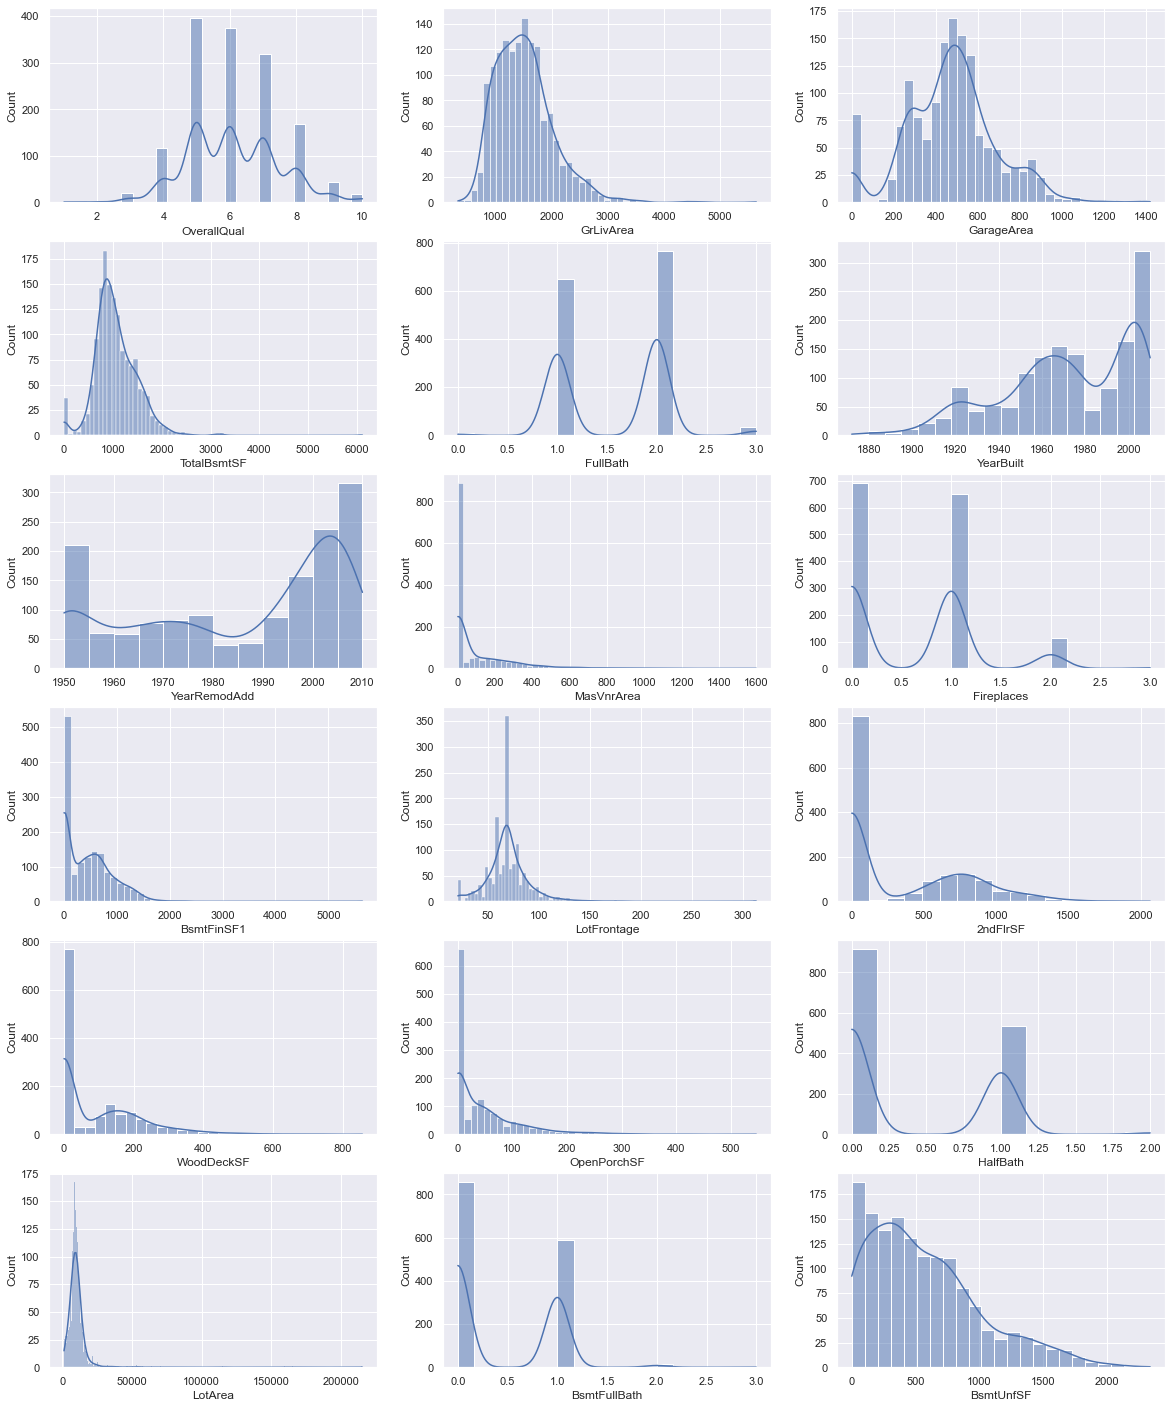

In [22]:
# distributions of selected features
fig = plt.figure(figsize = (20, 25))
j = 0
for i in test_num.columns:
    plt.subplot(6, 3, j+1)
    j += 1
    sns.histplot(train_num[i], kde=True)

plt.show()


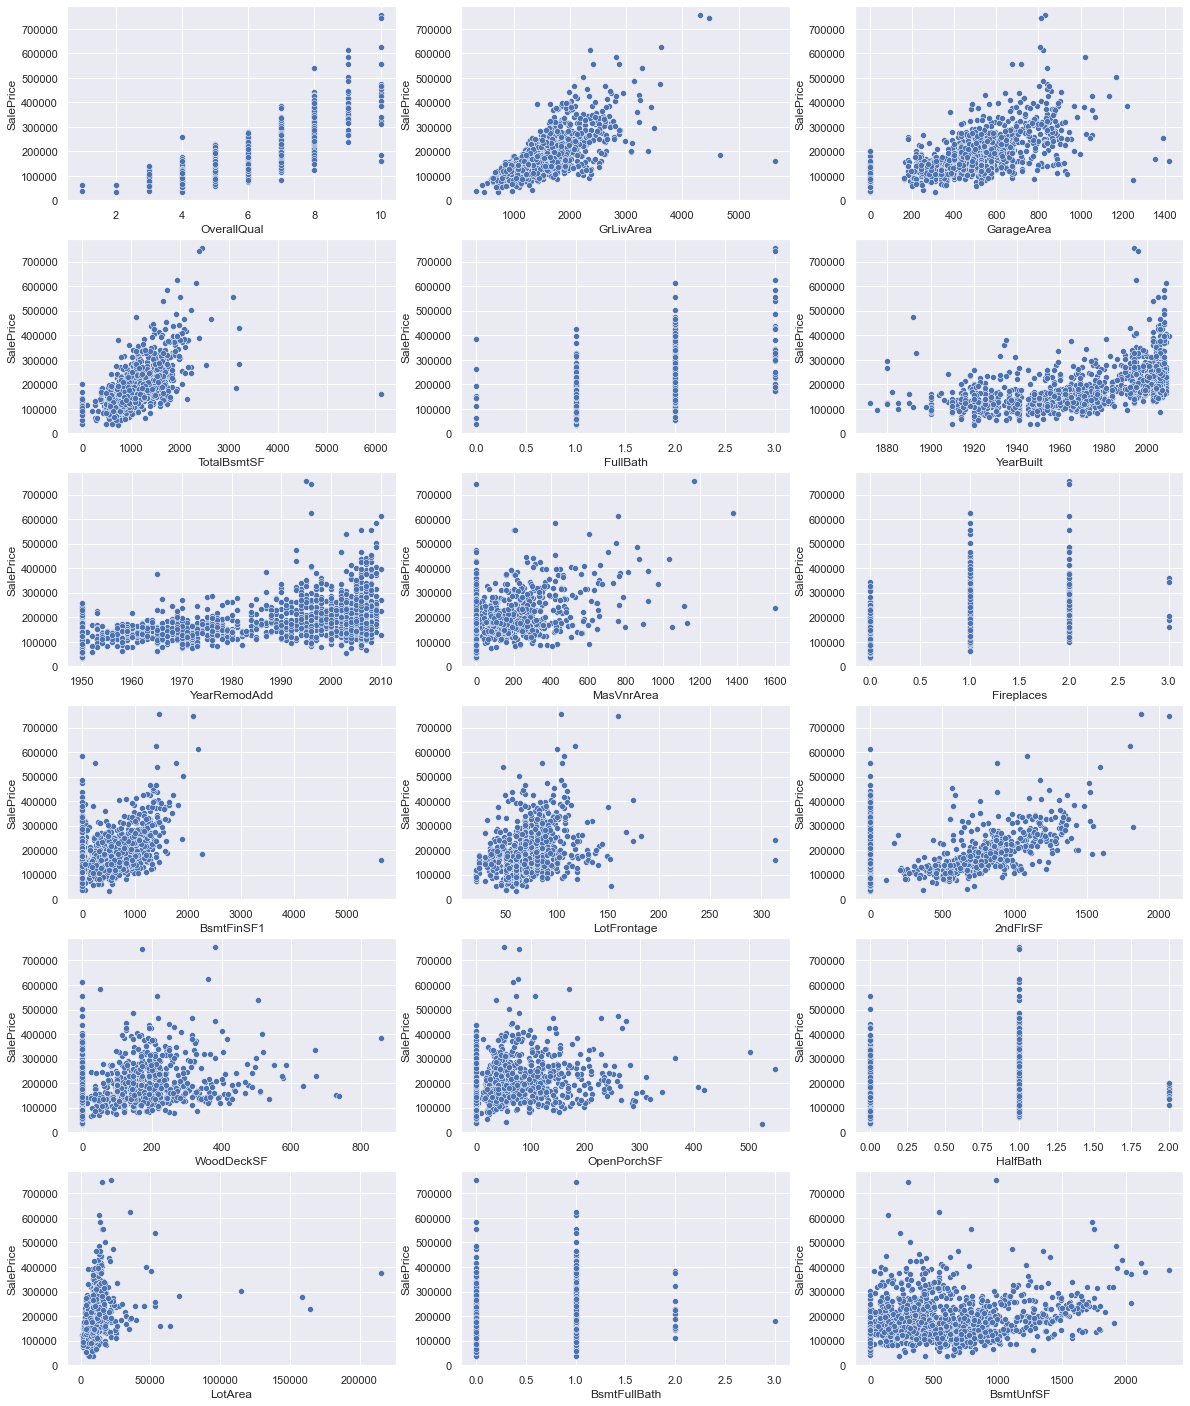

In [23]:
# scatter plot of the selected features and `SalePrice`.
fig = plt.figure(figsize = (20, 25))
j = 0
for i in test_num.columns:
    plt.subplot(6, 3, j+1)
    j += 1
    sns.scatterplot(x = train_num[i], y = train_num['SalePrice'])

plt.show()

## Categorical features
Now we focus on all categorical features.

In [24]:
# We select all categorical features, whose dtype are 'object'
categorical_columns = [column for column in train.columns if train[column].dtype == 'object']

# We append 'SalePrice' column because we will use this later
categorical_columns.append('SalePrice')
categorical_columns_test = [column for column in test.columns if test[column].dtype == 'object']

# We store all the categorical features in train_cat and test_cat
train_cat = train[categorical_columns].copy()
test_cat = test[categorical_columns_test].copy()

print('The number of categorical features for training set is: ', len(categorical_columns))
print('The number of caterigocal features for test set is: ', len(categorical_columns_test))
train_cat.head()

The number of categorical features for training set is:  39
The number of caterigocal features for test set is:  38


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,250000


### Feature Selection
We now investage the categorical features that have impact on `SalePrice`. 

In [25]:

#figure, axes = plt.subplots(8, 5, sharex=True, figsize=(40,20))

#k = 0
#for i in range(8):
#    if (k >= len(categorical_columns_test)):
#        break;
 #   for j in range(5):
  #      if (k >= len(categorical_columns_test)):
   #         break;
    #    sns.swarmplot(ax=axes[i, j],
     #                     data=train_cat,
      #                    x = categorical_columns_test[k],
       #                   y = 'SalePrice',
        #                  size=1)
        #k = k + 1

#plt.show()

We cannot deal with categorical variables directly, thus we use `sklearn.preprocessing`'s `LabelEncoder` method. This will encode target labels with value between 0 and n_classes-1.

In [26]:
# Encode the categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for feature in categorical_columns_test:
    label_encoder = label_encoder.fit(train_cat[feature].astype(str))
    train_cat[feature] = label_encoder.transform(train_cat[feature].astype(str)).astype(int)


We compute the correlations between the encoded categorical features and `SalePrice`. We do the same analysis as we did for numerical features:
- We keep those features which have absolute value of correlation >= 0.1, and drop the weak correlated features as they have little impact to the `SalePrice`.
- We also look at the correlations between features, if a pair of features are strongly correlated with each other, we only keep one of them, since they have almost same impact to the `SalePrice`.

In [27]:
# Compute the correlation matrix
corr_matrix_cat = train_cat.corr().round(2)

# Take the absolute value of the correlations with SalePrice and sort them in descending order
correlation_cat = np.abs(corr_matrix_cat['SalePrice']).sort_values(ascending=False)
print('The correlations of encoded categorical features with SalePrice are:')
corr_df_cat = pd.DataFrame(correlation_cat)
corr_df_cat.columns = ['corr_with_SalePrice']
corr_df_cat

The correlations of encoded categorical features with SalePrice are:


,corr_with_SalePrice
SalePrice,1.00
ExterQual,0.64
BsmtQual,0.62
KitchenQual,0.59
GarageFinish,0.55
GarageType,0.42
HeatingQC,0.40
Foundation,0.38
BsmtExposure,0.31
LotShape,0.26


The strong correlated encoded categorical features in descending orders are:
  ['SalePrice', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'GarageType', 'HeatingQC', 'Foundation', 'BsmtExposure', 'LotShape', 'CentralAir', 'Electrical', 'PavedDrive', 'RoofStyle', 'Neighborhood', 'SaleCondition', 'HouseStyle', 'MSZoning', 'RoofMatl', 'ExterCond', 'Functional', 'Exterior2nd', 'BsmtFinType1', 'Heating', 'Exterior1st']

These categorical features will be dropped:
 ['BldgType', 'Condition1', 'LotConfig', 'LandSlope', 'SaleType', 'Street', 'MasVnrType', 'GarageCond', 'BsmtCond', 'LandContour', 'BsmtFinType2', 'Condition2', 'GarageQual', 'Utilities']


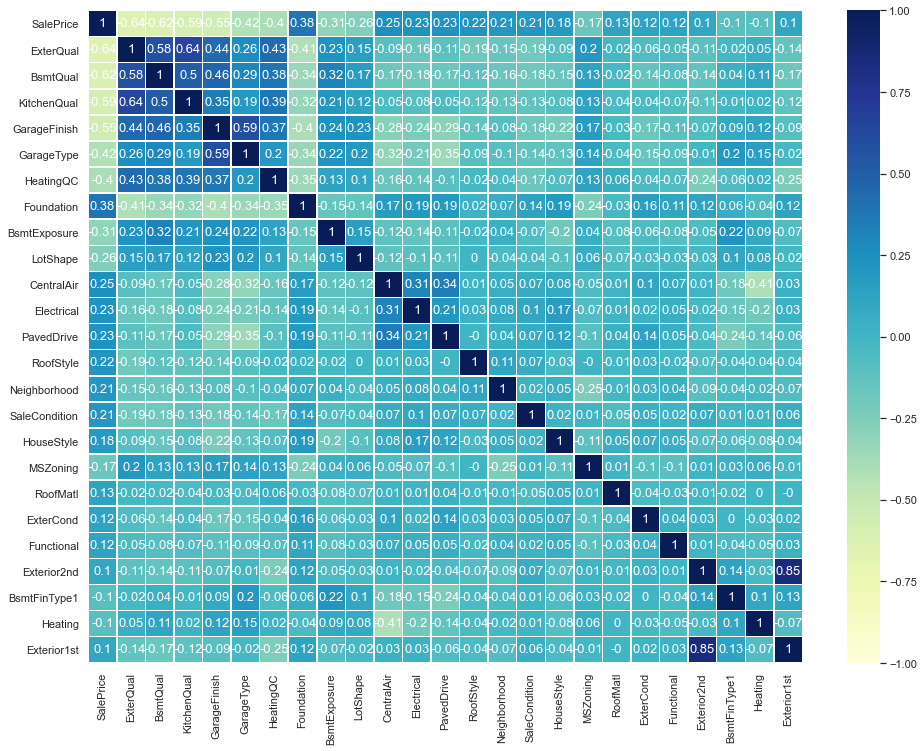

In [28]:
# We keep encoded categorical features which have correlation with SalePrice >= 0.1,
# store the features in strong_corr_columns_cat

strong_corr_columns_cat = list(correlation_cat[(correlation_cat >= .1)].index)
print('The strong correlated encoded categorical features in descending orders are:\n ', 
      strong_corr_columns_cat)
features_to_drop_cat = list(correlation_cat[(correlation_cat < .1)].index)

print()
print('These categorical features will be dropped:\n',
     features_to_drop_cat)
# We show the heatmap of the correlation matrix with strong_corr_columns_cat

plt.subplots(figsize = (16,12))
sns.heatmap(corr_matrix_cat.loc[strong_corr_columns_cat, strong_corr_columns_cat],
            vmax=1, vmin=-1,
            annot_kws={"size": 13, "color": "white"},
            linewidths=.5, cmap="YlGnBu",
            annot=True)
plt.show()

From the above heatmap, we see that `Exterior2nd` and `Exterior1st` have strong correlation of 0.85, hence we also drop one of them, here we drop `Exterior2nd`.



In [29]:
#We can confirm that the categorical features that we are going to drop actually have very weak correlations with the `SalePrice` by the following `sns.swarmplot`.
#Plot swarmplot of dropped features with SalePrice
#figure, axes = plt.subplots(5, 3, sharex=True, figsize=(20,10))

#k = 0
#for i in range(5):
#    if (k >= len(features_to_drop_cat)):
#        break;
#    for j in range(3):
#        if (k >= len(features_to_drop_cat)):
#            break;
#        sns.swarmplot(ax=axes[i, j],
#                          data=train_cat,
#                          x = features_to_drop_cat[k],
#                          y = 'SalePrice',
#                          size=2)
#        k = k + 1
#
#plt.show()

In [30]:
#for feature in features_to_drop_cat:
 #   print(train_cat.groupby(feature).SalePrice.mean())

In [31]:
# the categorical training data with selected features
train_cat = train[strong_corr_columns_cat[1:]].copy()

test_cat = test[strong_corr_columns_cat[1:]].copy()

# drop column 'Exterior2nd'
train_cat.drop(columns = 'Exterior2nd', inplace=True, axis=1)

test_cat.drop(columns = 'Exterior2nd', inplace=True, axis=1)
train_cat.head()

,ExterQual,BsmtQual,KitchenQual,GarageFinish,GarageType,HeatingQC,Foundation,BsmtExposure,LotShape,CentralAir,...,Neighborhood,SaleCondition,HouseStyle,MSZoning,RoofMatl,ExterCond,Functional,BsmtFinType1,Heating,Exterior1st
Id,,,,,,,,,,,,,,,,,,,,,
1,Gd,Gd,Gd,RFn,Attchd,Ex,PConc,No,Reg,Y,...,CollgCr,Normal,2Story,RL,CompShg,TA,Typ,GLQ,GasA,VinylSd
2,TA,Gd,TA,RFn,Attchd,Ex,CBlock,Gd,Reg,Y,...,Veenker,Normal,1Story,RL,CompShg,TA,Typ,ALQ,GasA,MetalSd
3,Gd,Gd,Gd,RFn,Attchd,Ex,PConc,Mn,IR1,Y,...,CollgCr,Normal,2Story,RL,CompShg,TA,Typ,GLQ,GasA,VinylSd
4,TA,TA,Gd,Unf,Detchd,Gd,BrkTil,No,IR1,Y,...,Crawfor,Abnorml,2Story,RL,CompShg,TA,Typ,ALQ,GasA,Wd Sdng
5,Gd,Gd,Gd,RFn,Attchd,Ex,PConc,Av,IR1,Y,...,NoRidge,Normal,2Story,RL,CompShg,TA,Typ,GLQ,GasA,VinylSd


#### Visualizing the data
We plot the scatterplot of the `SalePrice` and the selected encoded categorical features.

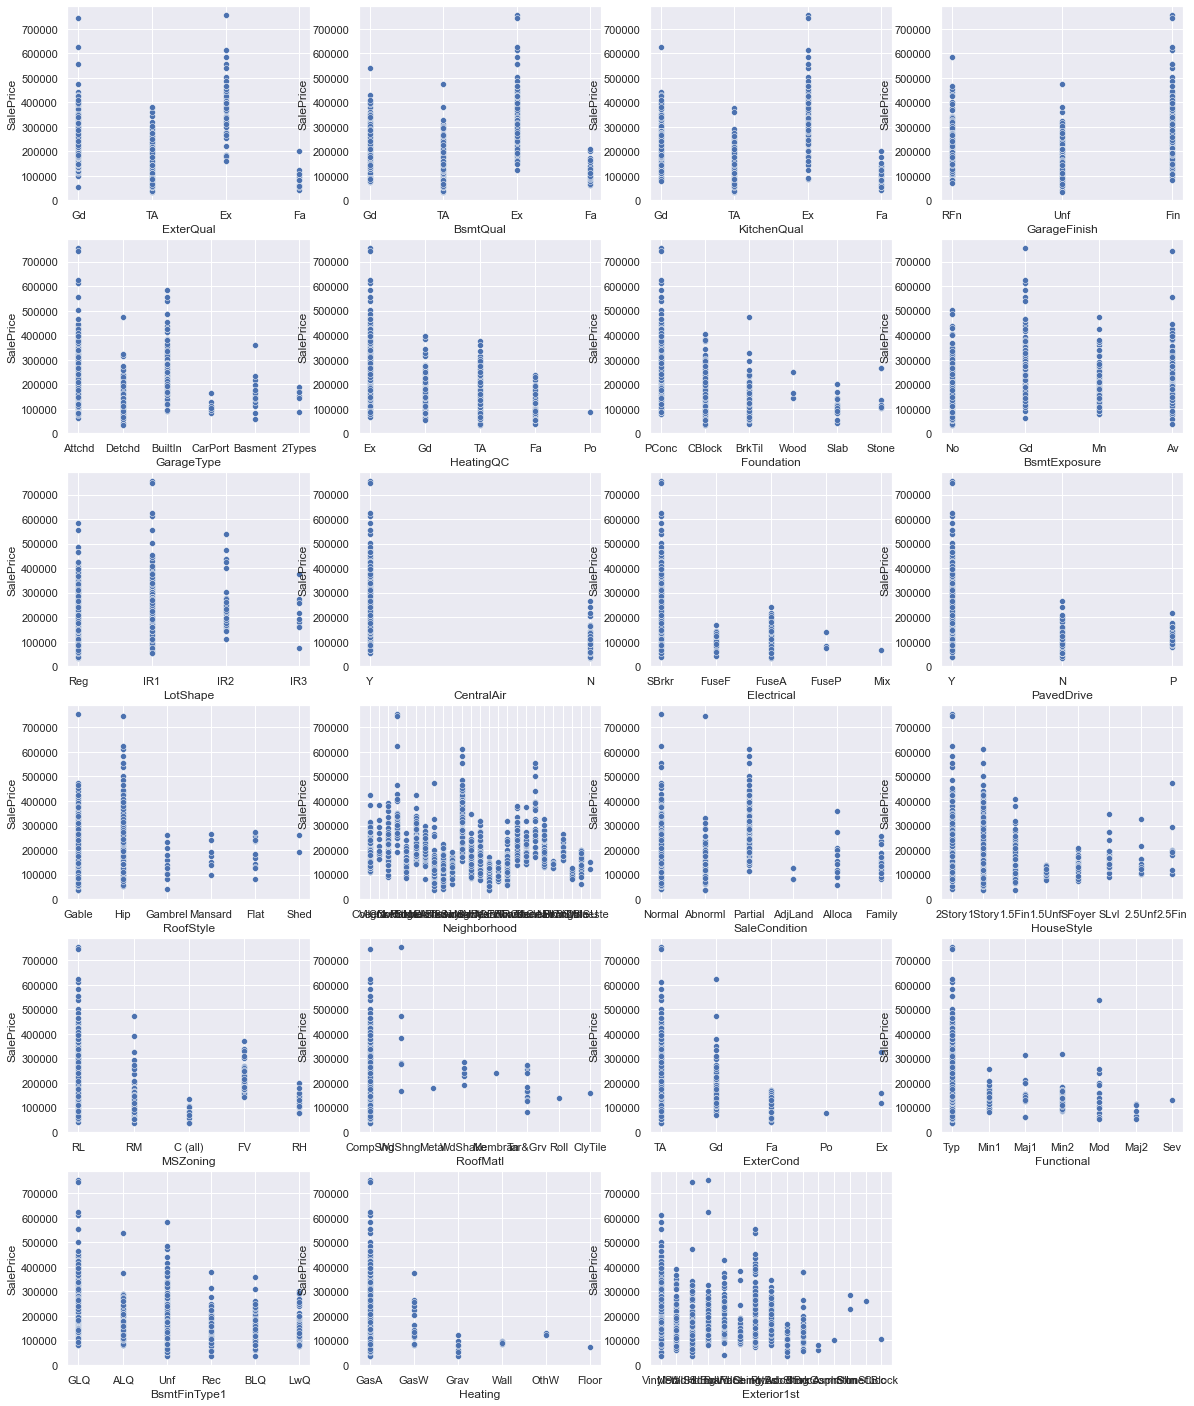

In [32]:
# scatter plot of the selected features and `SalePrice`.
fig = plt.figure(figsize = (20, 25))
j = 0
for i in test_cat.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.scatterplot(x = train_cat[i], y = train_num['SalePrice'])

plt.show()

## Missing values
Now we discuss columns with missing values. Since these features are categorical, we will fill in with the most frequent value in corresponding columns.

In [33]:
# We look at columns with missing value in training set
columns_with_nan_cat = train_cat.isnull().sum()[train_cat.isnull().sum() > 0]
number_of_nan_cat = columns_with_nan_cat.values
columns_with_nan_cat = list(columns_with_nan_cat.index)
print('The categorical columns with missing values in training set are:')
for i in range(len(columns_with_nan_cat)):
    print(columns_with_nan_cat[i], ': ', number_of_nan_cat[i])

The categorical columns with missing values in training set are:
BsmtQual :  37
GarageFinish :  81
GarageType :  81
BsmtExposure :  38
Electrical :  1
BsmtFinType1 :  37


In [34]:
# We look at columns with missing value in test set
columns_with_nan_cat_test = test_cat.isnull().sum()[test_cat.isnull().sum() > 0]
number_of_nan_cat_test = columns_with_nan_cat_test.values
columns_with_nan_cat_test = list(columns_with_nan_cat_test.index)
print('The categorical columns with missing values in test set are:')
for i in range(len(columns_with_nan_cat_test)):
    print(columns_with_nan_cat_test[i], ': ', number_of_nan_cat_test[i])

The categorical columns with missing values in test set are:
BsmtQual :  44
KitchenQual :  1
GarageFinish :  78
GarageType :  76
BsmtExposure :  44
MSZoning :  4
Functional :  2
BsmtFinType1 :  42
Exterior1st :  1


In [35]:
# We fill the missing values with the most frequent element in the corresponding columns

train_cat[columns_with_nan_cat] = train_cat[columns_with_nan_cat].apply(
                                                    lambda x: x.fillna(x.value_counts().index[0]))
test_cat[columns_with_nan_cat] = test_cat[columns_with_nan_cat].apply(
                                                    lambda x: x.fillna(x.value_counts().index[0]))

### One-hot encoding

We will use one-hot encoding to transform the categorical variables into numerical values. 

One-hot encoding is when one takes a categorical variable and represent it as a collection of new $0-1$ variables. Suppose we have a variable, $x$, with $k$ unique categories, then one-hot encoding is the process of creating $k-1$ indicator variables:

$$
1_j = \left\lbrace \begin{array}{l l} 1 & \text{if } x=j \\ 0 & \text{if } x \neq j\end{array} \right., \text{ for } j = 1, \dots, k-1.
$$

We only need $k-1$ of these variables because of the process of elimination. If all of the $1_j=0$, then that means that $x$ is not any of $1,\dots,k-1$ and thus it must be $k$.

In Python, `pd.get_dummies()` method can help us achieve this.

In [36]:
#train_cat.drop(columns = 'SalePrice', inplace=True)

# We notice that after pd.get_dummies, training set and test set may have different columns sizes,
# this is due to certain qualitative variables having values in one dataframe and not in the other.
# we fix this issume by concatenate the training set and test set together, apply pd.get_dummies and 
# split them.

df_dummies = pd.get_dummies(pd.concat([train_cat, test_cat]))
train_dummies = df_dummies.iloc[df_dummies.index.isin(train_cat.index)]
test_dummies = df_dummies.drop(train_cat.index)


In [37]:
# We chack if the shape of training set and test set agree after apply pd.get_dummies
print(train_dummies.shape, train_cat.shape)
print(test_dummies.shape, test_cat.shape)


(1460, 147) (1460, 23)
(1459, 147) (1459, 23)


## Combine numerical and categorical features together
Now we combine the numerical data and categorical data together to make a complete data for building the model.

In [38]:
# Combine numerical and categorical features together
train_new = pd.concat([train_num, train_dummies], axis=1)
test_new = pd.concat([test_num, test_dummies], axis = 1)
print('The preprocessed training set shape: ', train_new.shape)
print()
print('The preprocessed test set shape: ', test_new.shape)

The preprocessed training set shape:  (1460, 166)

The preprocessed test set shape:  (1459, 165)


The training set has one more column than the test set, which is the `SalePrice` column. We now split it into the predictors and target variable.

In [39]:
# All predictors
X = train_new.copy().drop(columns='SalePrice')

# 'SalePrice' in training set
y = train_new.loc[:,'SalePrice']

# The column size of training set and test set aggrees
print(X.shape)
print(y.shape)

(1460, 165)
(1460,)


## Build models

Now we build models to fit the trainint set. We will consider the following four models:
- Lasso Regression
- Ridge Regression
- Random Forest Regressor
- XGBoost regressor

We will use the Root-Mean-Squared-Error(RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price as the metric. 

In [40]:
# Split the data to staining and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   shuffle=True,
                                                   random_state=400,
                                                   test_size=.2)
print('The X_train shape: ', X_train.shape)
print('The X_test shape: ', X_test.shape)
print()
print('The y_train shape: ', y_train.shape)
print('The y_test shape: ', y_test.shape)

The X_train shape:  (1168, 165)
The X_test shape:  (292, 165)

The y_train shape:  (1168,)
The y_test shape:  (292,)


#### Lasso Regressio
We first look at a Lasso Regression model on the training set.

In [41]:
# Define the Lasso Regression object
lasso = Lasso(alpha=10)

# Fit the data
lasso.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test)

# Compute the RMSE
rmse_lasso = np.sqrt(mean_squared_error(np.log(y_pred_lasso), np.log(y_test)))
print('The RMSE for Lasso Regression is: ', rmse_lasso)

The RMSE for Lasso Regression is:  0.1628324698208212


There is a hyperparameter `alpha` in Lasso Regression, we now tuning this parameter and find an optimal one with lowest RMSE

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43620950936.209656, tolerance: 663973131.6485695
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170163172290.22513, tolerance: 663973131.6485695
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105250930927.79425, tolerance: 663973131.6485695
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWar

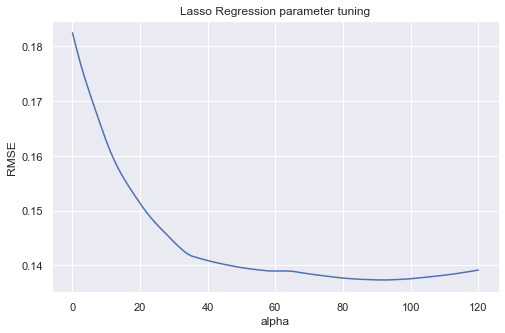

In [42]:
# Define a list of hyperparameters

alphas = list(np.linspace(.1, 120, 100))

# For each parameter in the list, train a model and compute the RMSE for X_test
rmse_lasso_list = []
for alpha in alphas:
    lasso = Lasso(alpha = alpha)

# Fit the data
    lasso.fit(X_train, y_train)

# Make predictions
    y_pred_lasso = lasso.predict(X_test)

# # Compute the RMSE
    rmse_lasso_list.append(np.sqrt(mean_squared_error(np.log(y_pred_lasso), np.log(y_test))))
    
chart = sns.lineplot(x=alphas, y=rmse_lasso_list)
chart.set(xlabel= 'alpha', ylabel='RMSE', title='Lasso Regression parameter tuning')

plt.show()

From the above lineplot of the `RMSE` and `alpha`, we see that the smallest `RMSE` happens when `alpha` is around 90, we use this parameter train the model again and compute RMSE.

In [43]:
# The Lasso Regression for optimal alpha 90

# Define the Lasso Regression object
lasso_opt = Lasso(alpha=90)

# Fit the data
lasso_opt.fit(X_train, y_train)

# Make predictions
y_pred_lasso_opt = lasso_opt.predict(X_test)

# Compute the RMSE
rmse_lasso_opt = np.sqrt(mean_squared_error(np.log(y_pred_lasso_opt), np.log(y_test)))
print('The RMSE for Lasso Regression with optimal alpha is: ', rmse_lasso_opt)

The RMSE for Lasso Regression with optimal alpha is:  0.13735593184568637


#### Ridge Regression
We first look at a Ridge Regression model, and then tuning the hyperparameter.

In [44]:
# Define the Rigde Regression object
ridge = Ridge(alpha = 1)

# Fit the data
ridge.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge.predict(X_test)

# Compute the RMSE
rmse_ridge = np.sqrt(mean_squared_error(np.log(y_pred_ridge), np.log(y_test)))

print('The RMSE of Ridge Regression is: ', rmse_ridge)

The RMSE of Ridge Regression is:  0.15877107325059425


Now we tune the hyperparameter `alpha`. 

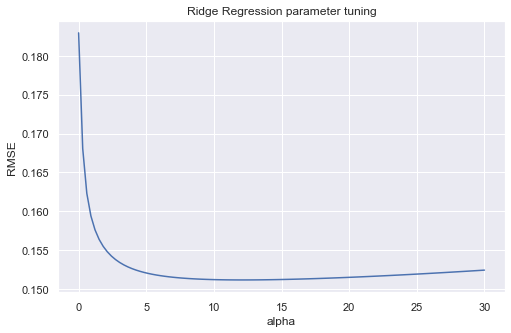

In [45]:
# Define a list of hyperparameters
alphas = list(np.linspace(0.001, 30, 100))
rmse_ridge_list = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha)

# Fit the data
    ridge.fit(X_train, y_train)

# Make predictions
    y_pred_ridge = ridge.predict(X_test)

# # Compute the RMSE
    rmse_ridge_list.append(np.sqrt(mean_squared_error(np.log(y_pred_ridge), np.log(y_test))))

# Plot the graph of RMSE with alpha
chart = sns.lineplot(x=alphas, y=rmse_ridge_list)
chart.set(xlabel= 'alpha', ylabel='RMSE', title='Ridge Regression parameter tuning')

plt.show()

From the above graph, we see that the optimal `alhpa` is around 12, next we use this parameter to train our Ridge Regression model.

In [46]:
# Ridge Regression for optimal alpha 12

# Define the Rigde Regression object
ridge_opt = Ridge(alpha = 12)

# Fit the data
ridge_opt.fit(X_train, y_train)

# Make predictions
y_pred_ridge_opt = ridge_opt.predict(X_test)

# Compute the RMSE
rmse_ridge_opt = np.sqrt(mean_squared_error(np.log(y_pred_ridge_opt), np.log(y_test)))

print('The RMSE of Ridge Regression with optimal alpha is: ', rmse_ridge_opt)

The RMSE of Ridge Regression with optimal alpha is:  0.15114521555321184


#### Random Forest Regressor

In [47]:
# Define the random forest object
forest = RandomForestRegressor()

# Fit the data
forest.fit(X_train, y_train)

# Make predictions
y_pred_forest = forest.predict(X_test)

# Compute the RMSE
rmse_forest = np.sqrt(mean_squared_error(np.log(y_pred_forest), np.log(y_test)))

print('The RMSE of Random Forest Regressor is: ', rmse_forest)

The RMSE of Random Forest Regressor is:  0.15927965172535186


In [48]:
# Define hyperparameters
params = { 
            'min_samples_leaf': [1, 2],
            'max_depth': [2, 3, 4],
            'n_estimators':[200, 500, 1000]}

# Define GridSearch and fit the data
forest_grid = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid=params,
                       cv = 5)

forest_grid.fit(X_train, y_train)

print("Best hyperparameters:\n", forest_grid.best_params_)

Best hyperparameters:
 {'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 500}


In [49]:
# Use the best parameters found in GridSearchCV, and apply Random Forest Regressor
forest_opt = RandomForestRegressor(min_samples_leaf = forest_grid.best_params_["min_samples_leaf"],
                             max_depth = forest_grid.best_params_["max_depth"],
                             n_estimators = forest_grid.best_params_["n_estimators"])

# Fit the data into model
forest_opt.fit(X_train, y_train)

# Make predictions
y_pred_forest_opt = forest_opt.predict(X_test)

# Compute the RMSE using optimal parameters
rmse_forest = np.sqrt(mean_squared_error(np.log(y_pred_forest_opt), np.log(y_test)))
print('The RMSE of the xgboost model with optimal parameters is: ', rmse_forest)

The RMSE of the xgboost model with optimal parameters is:  0.2080040954440855


From the above results, it looks that the defualt parameters for RandomForestRegressor is a better choice.

#### xgboost

In [50]:
# Define xgboost object
xgb = xgboost.XGBRegressor()

# Fit the data
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Compute the SMSE
rmse_xgb = np.sqrt(mean_squared_error(np.log(y_pred_xgb), np.log(y_test)))
print('The RMSE of Random Forest Regressor is: ', rmse_xgb)

The RMSE of Random Forest Regressor is:  0.168682021794858


##### Xgboost model hyperparameter tuning
There are hypermaters in the xgboost model, we will use `GridSearchCV`, search a grid of hyperparameters and find the optimal hyperparameters in this grid.

In [51]:
# Define hyperparameters
params = {'learning_rate':[.01, .05, .1],
        'colsample_bytree': [0.4, 0.6, 0.8],
        'max_depth': [3, 4],
        'n_estimators':[200, 500, 1000]}

# Define GridSearch and fit the data
xgb_grid = GridSearchCV(estimator=xgboost.XGBRegressor(),
                       param_grid=params,
                       cv = 5)

xgb_grid.fit(X_train, y_train)

print("Best hyperparameters:\n", xgb_grid.best_params_)

Best hyperparameters:
 {'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


In [52]:
# Use the best parameters found in GridSearchCV, and apply xgboost
xgb_opt = xgboost.XGBRegressor(colsample_bytree = xgb_grid.best_params_["colsample_bytree"],
                             learning_rate = xgb_grid.best_params_["learning_rate"],
                             max_depth = xgb_grid.best_params_["max_depth"],
                             n_estimators = xgb_grid.best_params_["n_estimators"])

# Fit the data into model
xgb_opt.fit(X_train, y_train)

# Make predictions
y_pred_xgb_opt = xgb_opt.predict(X_test)

# Compute the RMSE using optimal parameters
rmse_xgb = np.sqrt(mean_squared_error(np.log(y_pred_xgb_opt), np.log(y_test)))
print('The RMSE of the xgboost model with optimal parameters is: ', rmse_xgb)

The RMSE of the xgboost model with optimal parameters is:  0.1376920489874895


## Make Predictions

By comparing the above three models, we found that xgboost in the optimal parameters has best performance, hence we use xgboost model as our final model to make the prediction for the test set. We save the prediction to a file named `submission.csv`. As a comparison, we also save the Lasso Regression predictions in a file named `lasso_submission.csv`.

In [53]:
# Make predictions using the xgboost model with optimal parameters
y_pred = xgb_opt.predict(test_new)

# Create a dataframe submission
submission = pd.DataFrame({'Id': test_new.index,
                          'SalePrice': y_pred})

# Save the predictions in a csv file named submission.csv
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,SalePrice
0,1461,126442.718750
1,1462,160120.390625
2,1463,179746.546875
3,1464,188976.390625
4,1465,189034.265625


In [54]:
# Make predictions using the Lasso Regression model with optimal parameters
y_pred = lasso.predict(test_new)

# Create a dataframe submission
lasso_submission = pd.DataFrame({'Id': test_new.index,
                          'SalePrice': y_pred})

# Save the predictions in a csv file named submission.csv
lasso_submission.to_csv('lasso_submission.csv', index=False)
lasso_submission.head()

,Id,SalePrice
0,1461,119607.628818
1,1462,161446.293476
2,1463,173668.848506
3,1464,189560.270305
4,1465,214366.284691


## Conclusion
I submitted both files in Kaggle, the public scores for the two models are:
- xgboost: 0.14546,
- Lasso regression: 0.15212.

This shows that xgboost is slightly better than Lasso regression, which is #2021 on the Kaggle Leaderboard.

## This is the End of the notebook